In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

2024-06-27 13:59:46.875195: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-27 13:59:47.030119: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 13:59:47.030148: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 13:59:47.031060: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 13:59:47.122697: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-27 13:59:47.126032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# mnist corresponds to federated emnist(only_digits=True)
train_ds, val_ds = tfds.load('mnist', split=['train[:80%]', 'train[80%:]'])
test_ds = tfds.load('mnist', split='test')
len(train_ds), len(val_ds), len(test_ds)

(48000, 12000, 10000)

2024-06-27 13:59:51.075866: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<matplotlib.image.AxesImage at 0x79ab046c9890>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>)

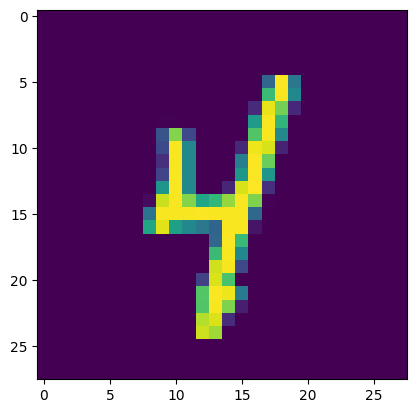

In [3]:
ex = next(iter(train_ds))
plt.imshow(ex['image']), ex['label']

In [4]:
ex['image'].numpy().max()  # pixels should be scaled down between 0 and 1

255

In [5]:
def preprocess_ds(ds, is_train=False):
    def element_fn(element):
        image = element['image']
        label = element['label']
        image = tf.cast(image, dtype=tf.float32) / 255.  # rescale image
        return (image, label)
    
    if is_train:
        return (
            ds
            .map(element_fn)
            .shuffle(128)
            .batch(512)  # just increasing the batch size improved the training process a lot idk why
        )
    else:
        return (
            ds
            .map(element_fn)
            .batch(512)
        )

In [6]:
train = preprocess_ds(train_ds, is_train=True)
val = preprocess_ds(val_ds)
test = preprocess_ds(test_ds)

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10),
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer, 
    loss=loss_object, 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

In [12]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
94/94 [==============================] - 12s 124ms/step - loss: 0.7568 - accuracy: 0.7659 - val_loss: 0.1833 - val_accuracy: 0.9493
Epoch 2/10
94/94 [==============================] - 10s 105ms/step - loss: 0.1726 - accuracy: 0.9474 - val_loss: 0.1034 - val_accuracy: 0.9711
Epoch 3/10
94/94 [==============================] - 10s 106ms/step - loss: 0.1187 - accuracy: 0.9635 - val_loss: 0.0789 - val_accuracy: 0.9772
Epoch 4/10
94/94 [==============================] - 9s 97ms/step - loss: 0.0954 - accuracy: 0.9705 - val_loss: 0.0670 - val_accuracy: 0.9799
Epoch 5/10
94/94 [==============================] - 10s 107ms/step - loss: 0.0819 - accuracy: 0.9745 - val_loss: 0.0597 - val_accuracy: 0.9823
Epoch 6/10
94/94 [==============================] - 12s 124ms/step - loss: 0.0704 - accuracy: 0.9779 - val_loss: 0.0534 - val_accuracy: 0.9829
Epoch 7/10
94/94 [==============================] - 12s 123ms/step - loss: 0.0610 - accuracy: 0.9814 - val_loss: 0.0479 - val_accuracy: 0.9853
E

In [13]:
model.evaluate(test)

20/20 [==============================] - 1s 25ms/step - loss: 0.0339 - accuracy: 0.9882


[0.03394725173711777, 0.9882000088691711]

Text(0.5, 1.0, 'Accuracy on MNIST')

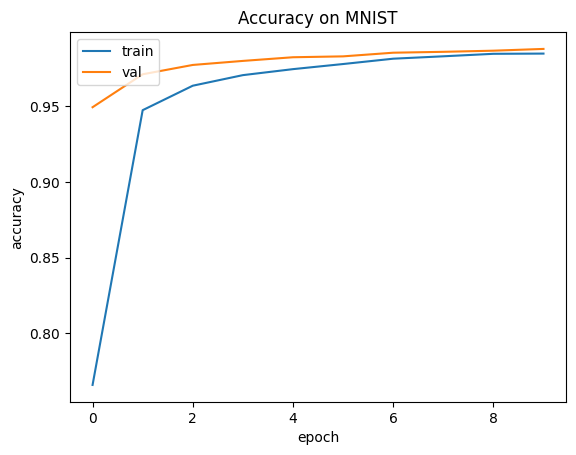

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy on MNIST')